In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
%matplotlib inline

In [86]:
path = "./data/" 
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [ ]:
##conda install keras-gpu 하면 gpu도 괴롭힐 수 있음

## 전처리
 - 이상치 확인 및 처리

In [87]:
train_df.shape

(199991, 22)

In [88]:
train_df.describe()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [89]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [90]:
train_df = del_outlier(train_df, min=-60, max=60)

In [91]:
train_df.columns, train_df.shape

(Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
        'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
        'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
        'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
        'modelMag_z'],
       dtype='object'), (199805, 22))

## DATA Setting

In [92]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [93]:
def add_minus_feature(data,test = False):
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [94]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

In [95]:
train_X = train_df.drop(columns=['type', 'type_num'], axis=1)
train_y = train_df['type_num']
test_X = test_df

In [96]:
train_X.head()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,...,petroMag_g-i,petroMag_g-z,petroMag_r-i,petroMag_r-z,petroMag_i-z,modelMag_u-g,modelMag_u-r,modelMag_u-i,modelMag_u-z,modelMag_g-r,modelMag_g-i,modelMag_g-z,modelMag_r-i,modelMag_r-z,modelMag_i-z
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,...,0.286226,1.009190,0.332902,1.055866,0.722964,1.283708,1.385054,1.728637,1.601901,0.101347,0.444929,0.318194,0.343582,0.216847,-0.126735
1,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,...,0.139156,0.132308,0.249893,0.243045,-0.006847,0.734428,0.739030,0.799566,0.980641,0.004602,0.065138,0.246213,0.060537,0.241611,0.181074
2,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,...,-0.005426,-0.069222,-0.055336,-0.119132,-0.063796,1.120628,1.176814,1.157885,1.129134,0.056186,0.037257,0.008506,-0.018929,-0.047680,-0.028751
3,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,...,0.242810,0.538610,0.234614,0.530413,0.295800,0.769012,0.880913,1.012598,1.217856,0.111901,0.243586,0.448844,0.131685,0.336943,0.205258
4,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,...,2.816917,4.050788,2.063539,3.297411,1.233871,1.729059,3.401710,5.389723,6.501398,1.672651,3.660663,4.772338,1.988012,3.099688,1.111675


In [97]:
train_X.columns

Index(['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z',
       'psfMag_u-g', 'psfMag_u-r', 'psfMag_u-i', 'psfMag_u-z', 'psfMag_g-r',
       'psfMag_g-i', 'psfMag_g-z', 'psfMag_r-i', 'psfMag_r-z', 'psfMag_i-z',
       'fiberMag_u-g', 'fiberMag_u-r', 'fiberMag_u-i', 'fiberMag_u-z',
       'fiberMag_g-r', 'fiberMag_g-i', 'fiberMag_g-z', 'fiberMag_r-i',
       'fiberMag_r-z', 'fiberMag_i-z', 'petroMag_u-g', 'petroMag_u-r',
       'petroMag_u-i', 'petroMag_u-z', 'petroMag_g-r', 'petroMag_g-i',
       'petroMag_g-z', 'petroMag_r-i', 'petroMag_r-z', 'petroMag_i-z',
       'modelMag_u-g', 'modelMag_u-r', 'modelMag_u-i', 'modelMag_u-z',
       'modelMag_g-r', 'modelMag_g-i', 'modelMag_g-z', 'modelMag_r-i',
       'modelMag_r-z', 'modelMag_i-z'],


In [98]:
## u-g, g-r, r-i, i-z 만 남기는게 좋지 않을까????
train_X.drop(['psfMag_u-r','psfMag_u-i','psfMag_u-z','psfMag_g-i','psfMag_g-z','psfMag_r-z',
             'fiberMag_u-r','fiberMag_u-i','fiberMag_u-z','fiberMag_g-i','fiberMag_g-z','fiberMag_r-z',
             'petroMag_u-r','petroMag_u-i','petroMag_u-z','petroMag_g-i','petroMag_g-z','petroMag_r-z',
             'modelMag_u-r','modelMag_u-i','modelMag_u-z','modelMag_g-i','modelMag_g-z','modelMag_r-z'] ,axis=1, inplace=True)

test_X.drop(['psfMag_u-r','psfMag_u-i','psfMag_u-z','psfMag_g-i','psfMag_g-z','psfMag_r-z',
             'fiberMag_u-r','fiberMag_u-i','fiberMag_u-z','fiberMag_g-i','fiberMag_g-z','fiberMag_r-z',
             'petroMag_u-r','petroMag_u-i','petroMag_u-z','petroMag_g-i','petroMag_g-z','petroMag_r-z',
         'modelMag_u-r','modelMag_u-i','modelMag_u-z','modelMag_g-i','modelMag_g-z','modelMag_r-z'] ,axis=1, inplace=True)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [100]:
o_hot = OneHotEncoder()
y_train= o_hot.fit_transform(y_train.values.reshape(-1,1))
y_train = y_train.toarray()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [101]:
o2_hot = OneHotEncoder()
y_test= o2_hot.fit_transform(y_test.values.reshape(-1,1))
y_test = y_test.toarray()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [102]:
y_train.shape, y_test.shape

((139863, 19), (59942, 19))

In [103]:
X_train = X_train.values
X_train.shape

(139863, 37)

In [104]:
X_test = X_test.values
X_test.shape

(59942, 37)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import BatchNormalization
model = Sequential()
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(60, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(19, activation='softmax'))


from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

## 얼리스타핑
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

##최적모델 기억
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(0.001), metrics=['accuracy','categorical_crossentropy'])

history=model.fit(X_train, y_train, validation_data=(X_test, y_test)  ,batch_size=100, epochs=100, verbose=1,
                 callbacks=[es, mc])
### validation_data를 쓰면 test 데이터가 따로있을때 직접 넣을 수 있다.
model.evaluate(X_test, y_test)

Train on 139863 samples, validate on 59942 samples
Epoch 1/100
139863/139863 [==============================] - 10s 68us/step - loss: 0.8533 - acc: 0.7466 - categorical_crossentropy: 0.8533 - val_loss: 0.6708 - val_acc: 0.7759 - val_categorical_crossentropy: 0.6708
Epoch 2/100
139863/139863 [==============================] - 7s 52us/step - loss: 0.5734 - acc: 0.8136 - categorical_crossentropy: 0.5734 - val_loss: 0.7356 - val_acc: 0.7670 - val_categorical_crossentropy: 0.7356
Epoch 3/100
139863/139863 [==============================] - 10s 72us/step - loss: 0.5337 - acc: 0.8230 - categorical_crossentropy: 0.5337 - val_loss: 0.5117 - val_acc: 0.8315 - val_categorical_crossentropy: 0.5117
Epoch 4/100
139863/139863 [==============================] - 7s 49us/step - loss: 0.5142 - acc: 0.8278 - categorical_crossentropy: 0.5142 - val_loss: 0.6871 - val_acc: 0.7438 - val_categorical_crossentropy: 0.6871
Epoch 5/100
139863/139863 [==============================] - 7s 50us/step - loss: 0.5010 - 

In [82]:
history.history['val_loss']

[1.7717303612728215,
 1.94398530668694,
 1.9647822869635052,
 1.9640667722234646,
 1.8772526433688093,
 2.122905674217232,
 2.0634095739923306,
 1.8566691418672276,
 1.8609463092927048,
 2.3660943235944574]

In [83]:
history.history['val_categorical_crossentropy']

[1.7717303612728215,
 1.94398530668694,
 1.9647822869635052,
 1.9640667722234646,
 1.8772526433688093,
 2.122905674217232,
 2.0634095739923306,
 1.8566691418672276,
 1.8609463092927048,
 2.3660943235944574]

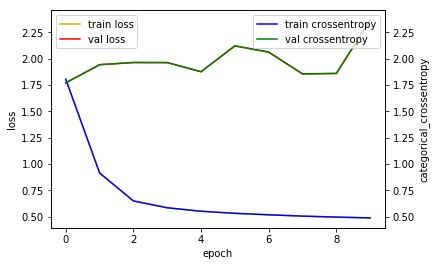

In [84]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['categorical_crossentropy'], 'b', label='train crossentropy')
acc_ax.plot(history.history['val_categorical_crossentropy'], 'g', label='val crossentropy')
acc_ax.set_ylabel('categorical_crossentropy')
acc_ax.legend(loc='upper right')

plt.show()

In [32]:
real_y_pred = model.predict(test_X)

In [35]:
submission = pd.DataFrame(data=real_y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('submission_keras.csv', index=True)